Author: Sean Tulin
<br>
Date: Jan. 23, 2023
<br>
PHYS 2030 W23

# <center><font color=#46769B>Lesson 3: Sampling from arbitrary distributions</font></center>

## <font color=#46769B>Discrete distributions</font>

It is straightforward to generalize flipping a coin to situations where there are more than two outcomes.
For example, suppose we roll an $n$-sided die, with probabilities $p_i$ for getting each side $i$. (We imagine the die is unevenly weighted so that the probabilities need not be equal in general.)

The PDF would be
$$P(x) = \left\{ \begin{array}{cc} p_1 & {\rm for} \; x=a_1 \\
p_2 & {\rm for} \; x=a_2 \\
\vdots & \\
p_n & {\rm for} \; x=a_n \end{array} \right.$$

where $a_i$ labels the outcome of side $i$. This is known as a __categorical distribution__.

It is easy to sample from this distribution using `numpy.random.choice()`, as the following code illustrates. Note we use the keyword `p=prob` to assign probabilities to each choice. (By default, equal probabilities are assumed for each option.)

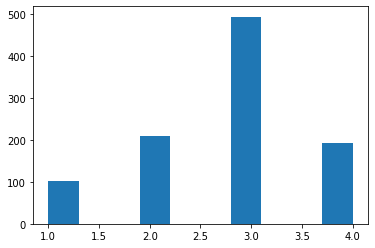

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# List of outcome options
options = [1, 2, 3, 4]

# Probabilities of outcomes (Note: total = 1)
prob = [0.1, 0.2, 0.5, 0.2]

# Number of samples
num = 1000

# Generate samples
samples = np.random.choice(options,num,p=prob)

# Make a bar graph of our samples
plt.hist(samples)
plt.show()

### <font color=#46769B>Alternative method</font>

Next, we write an alternative code for sampling that will accomplish the same thing. We don't *need* to do it this way given the `numpy` version is very simple, but the logic here is similar to what we will do for continuous distributions.

We assign each outcome $a_i$ to a line segment of length $p_i$. Since the total probability is $\sum_{i=1}^n p_i = 1$, the total length of all line segments is 1. So, we can divide up the range \[0,1\] into intervals, each assigned to a different outcome. For example, the first interval $[0,p_1]$ corresponds to $a_1$, the next interval $[p_1,p_1+p_2]$ corresponds to $a_2$, the next interval $[p_1+p_2,p_1+p_2+p_3]$ corresponds to $a_3$, and so on. The final interval 

$$[p_1 + p_2 + ... + p_{n-1}, \, p_1 + p_2 + ... + p_{n-1} + p_n] = [1-p_n,\, 1]$$ 

corresponds to $a_n$.

Now, to sample, we choose a random number $r$ between \[0,1\]. Which interval $r$ falls into will tell us the value $a_i$ we obtain. Here is a code to illustrate this:



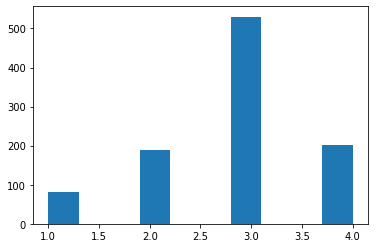

In [3]:
# Generate samples 
# Same options and prob as above 
samples = []

for k in range(num):
    
    r = np.random.rand()
    
    if r < prob[0]:
        samples.append(options[0])
    elif r < prob[0] + prob[1]:
        samples.append(options[1])
    elif r < prob[0] + prob[1] + prob[2]:
        samples.append(options[2])
    else:
        samples.append(options[3])

# Make a bar graph of our samples
plt.hist(samples)
plt.show()

Note that the important quantities above are the __cumulative probabilities__

$$c_i = \sum_{j=1}^{i} p_j \, .$$

That is, $c_1 = p_1$ is the probability for result $a_1$, $c_2 = p_1 + p_2$ is the probability for *either* $a_1$ or $a_2$, and so forth. Finally, $c_n = p_1 + ... + p_n = 1$ is probability for getting *any* outcome. 

The intervals we defined above are simply written as $[0,c_1]$, $[c_1,c_2]$, $[c_2,c_3]$, etc. We can summarize the logic as follows:
> Select a random number $r$ from a uniform distribution between $[0,1]$. If $r$ falls within the $i$th cumulative probability interval $[c_{i-1},c_i]$, then our sample value is $a_i$. (For $i=1$, the first interval is $[0,c_1]$.)

This procedure will select each value of $a_i$ with probability $p_i$, exactly as we wanted.

There is a built-in function `numpy.cumsum` for calculating the *cumulative* sum of a list, which is exactly what we need to do to calculate $c_i$ from $p_i$. Documentation is [here](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html).
We can use this to rewrite above code so that it works automatically for any number of options.

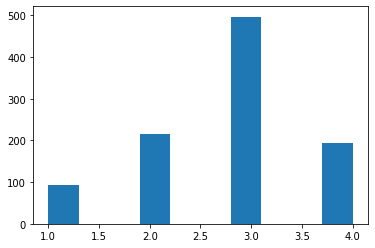

In [9]:
c = np.cumsum(prob)

samples = []

for k in range(num):
    
    r = np.random.rand()
    
    for i in range(len(c)):
        
        # We want c[i-1] < r < c[i]
        # But only need to check upper limit since failing the previous time will 
        # automatically imply r > c[i-1]
        if r < c[i]:
            samples.append(options[i])
            break # exit for loop
        
# Make a bar graph of our samples
plt.hist(samples)
plt.show()

## <font color=#46769B>Cumulative distribution functions</font>

We now turn to the question of how to sample from a continous probability distribution function $P(x)$. However, before we get there, we will first discuss __cumulative distribution functions (CDFs)__. 

Suppose our PDF $P(x)$ takes values over the domain $-\infty < x < +\infty$.
The CDF $C(x)$, defined as
$$C(x) = \int_{-\infty}^x dz \, P(z) \, ,$$
corresponds to the *cumulative* probability for obtaining any result less than or equal to $x$.
Note that $C(-\infty) = 0$ and $C(+\infty)=1$, and that $C(x)$ is a non-decreasing function between these values.

### <font color=#46769B>Example: CDF for uniform distribution</font>

Let's consider a uniform PDF that is nonzero only over the interval $[0,1]$. That is,
$$P(x) = \left\{ \begin{array}{cc} 1 & {\rm for} \; 0 \le x \le 1 \\ 0 & {\rm otherwise} \end{array} \right. \, .$$
We can calculate the CDF analytically to be
$$C(x) = \left\{ \begin{array}{cc} 0 & {\rm for} \; x < 0 \\
x & {\rm for} \; 0 \le x \le 1 \\ 1 & {\rm for} \; x > 1\end{array} \right. \, .$$

Here is a plot of the two quantities.

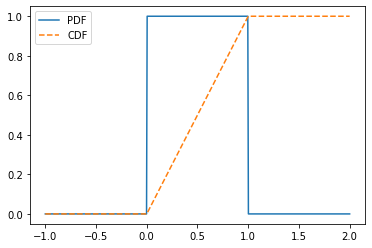

In [4]:
x = np.linspace(-1,2,num=500)

# Initialize PDF, CDF as an array of zeros
PDF = np.zeros_like(x)
CDF = np.zeros_like(x)

# Populate nonzero entries of PDF and CDF
for i in range(len(x)):
    if (x[i] > 0) and (x[i] < 1):
        PDF[i] = 1
        CDF[i] = x[i]
    elif x[i] > 1:
        CDF[i] = 1
    
plt.plot(x,PDF,label='PDF')
plt.plot(x,CDF,'--',label='CDF')
plt.legend()
plt.show()

### <font color=#46769B>Example: CDF for normal distribution</font>

Let's consider our PDF to be normal distribution $\mathcal{N}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{- \frac{(x-\mu)^2}{2 \sigma^2}}$. The CDF is
$$C(x) = \int_{-\infty}^x dz \, \mathcal{N}(z) 
= \int_{-\infty}^{\mu} dz \, \mathcal{N}(z) + \int_{\mu}^{x} dz \, \mathcal{N}(z) $$
where we have simply divided the integration into two parts.
The first term, an integral over one half of a Gaussian, is $\tfrac{1}{2}$. The second term can be expressed as
$$\int_{\mu}^{x} dz \, \mathcal{N}(z) = \frac{1}{\sqrt \pi}\int_{0}^{\frac{x-\mu}{\sqrt{2} \sigma}} du \, e^{-u^2}$$
using a change of substitution $u = \frac{z-\mu}{\sqrt{2}\sigma}$.
This integral, which cannot be evaluated analytically, is a special function known as the __error function__ (denoted as __erf__):
$${\rm erf}(x) = \frac{2}{\pi} \int_0^{x} du \, e^{-u^2}\, .$$
Thus, the CDF for a normal distribution is
$$C(x) = \frac{1}{2} \left[ 1 + {\rm erf}\left( \frac{x-\mu}{\sqrt{2} \sigma} \right) \right] \, .$$
We can import the error function from the `scipy.special` package, which contains useful implementations of many special functions. (See [here](https://docs.scipy.org/doc/scipy/reference/special.html) for documentation.)

Here we plot the PDFs and CDFs for different normal distributions. Feel free to explore and modify this code as you like. You may note that the CDF is steepest where the PDF is largest. This is no surprise is the PDF is simply the derivative of the CDF.

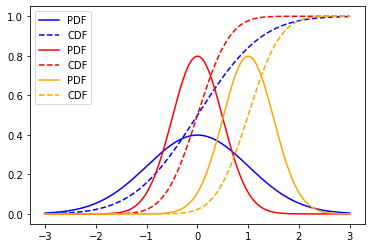

In [5]:
from scipy.special import erf

# This function will plot the PDF and CDF for given mu, sigma

def plot_normal_dist(mu,sigma,color):
    
    x = np.linspace(-3,3,num=500)
    PDF = 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*(x-mu)**2/sigma**2)
    CDF = 0.5*(1 + erf((x-mu)/sigma/np.sqrt(2)))
    
    plt.plot(x,PDF,color=color,label='PDF')
    plt.plot(x,CDF,'--',color=color,label='CDF')

plot_normal_dist(0,1,'blue')
plot_normal_dist(0,0.5,'red')
plot_normal_dist(1,0.5,'orange')
plt.legend()
plt.show()


## <font color=#46769B>Sampling continuous distributions</font>

Recall for a discrete distribution with $n$ choices, each value for $x$ corresponds to a interval in the cumulative probability, which all together span the domain $[0,1]$. Sampling amounts to choosing a random number $r$, finding which interval $r$ lies within, and selecting that value of $x$.

Sampling from continuous distributions follows the same logic. In the figure below, we show an example of a PDF and CDF for a normal distribution. Consider the range between $x$ and $x + \Delta x$ (gray vertical lines), where $\Delta x$ is infinitesimally small.
According to the definition of a PDF, the probability to sample $x$ within this range is $P(x) \Delta x$.

![Caption: smapling figure](https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/raw/main/Sampling_figure.png)

Now, suppose we select a random number $r$ from the domain $[0,1]$. The CDF allows us to map every value of $r$ to a value of $x$, according to the formula $r = C(x)$, shown by the red lines.
If we want to pick a value of $x$ between $x$ and $x + \Delta x$, we need to pick a value of $r$ between $C(x)$ and $C(x + \Delta x)$.
The probability of choosing $r$ in this range is
$$C(x + \Delta x) - C(x) = C(x) + \frac{dC}{dx} \Delta x - C(x) = P(x) \Delta x$$
where we have Taylor expanded $C(x + \Delta x)$ around $x$ and kept only the leading term in $\Delta x$.
That is, this is exactly as we want!

The procedure for sample $x$ is as follows:
- Select a random number $r$ from the domain $[0,1]$.
- Find the corresponding value of $x$ according to the equation $$x = C^{-1}(r)$$ where $C^{-1}$ is the __inverse CDF__. (Equivalently, you could have written $r = C(x)$.)
- Repeating this process $N$ times will generate $N$ samples for $x$ from $P(x)$.



### <font color=#46769B>Example: Sampling from an exponential distribution</font>

Consider an exponential probability distribution
$$P(x) = \left\{ \begin{array}{cc} a e^{-ax} & {\rm for} \; x > 0 \\ 0 & {\rm otherwise} \end{array} \right.$$
where $a$ is a positive, real constant. Let's draw random samples for $x$ from this PDF.

First, we need to calculate the CDF. By integrating the PDF, we find
$$C(x) = \left\{ \begin{array}{cc} 1 - e^{-ax} & {\rm for} \; x > 0 \\ 0 & {\rm otherwise} \end{array} \right. \, .$$ 
Next, we want to solve the equation $r = C(x)$ for $x$. This yields
$$x = - \frac{1}{a} \ln\left( 1- r \right)\, . \qquad {\rm (1)}$$
The function in Eq. (1) is the inverse CDF. So, we draw $N$ samples for $x$ by drawing $N$ random values for $r$, drawn uniformly from the domain $[0,1]$, and plug each value of $r$ into Eq. (1). 

Here is a code that implements this. We draw samples for $x$ and compare the original PDF. Try:
- Increasing the number of samples `num` and number of `bins` in the histogram.
- Changing the value of `a`
- Changing the y-axis to a log scale using `plt.yscale('log')`


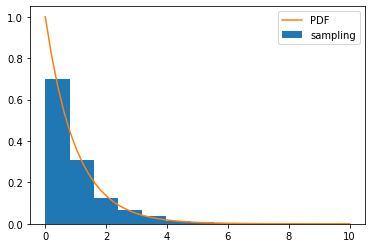

In [6]:
num = 1000
a = 1

r = np.random.rand(num)
x_samples = -1/a * np.log(1-r)
plt.hist(x_samples,bins=10,density=True,label='sampling')

# Compare to original PDF
x = np.linspace(0,10)
PDF = a*np.exp(-a*x)
plt.plot(x,PDF,label='PDF')

plt.legend()
plt.show()

## <font color=#46769B>Quantile function</font>

The inverse CDF $C^{-1}$ is also known as the __quantile function__. The $p$th quantile is a value of $x$, denoted $x_p$, where the probability to find a value $x \le x_p$ is $p$. ($p$ is often quoted as a percentage.) For example, the 25\%-quantile is the value $x_{25}$ where 25\% of $x$ values satisfy $x \le x_{25}$, while the remaining 75\% are above this value, $x > x_{25}$. The quantile is simply
$$x_p = C^{-1}(p) \, .$$

The __median__ is $x_{50} = C^{-1}(0.5)$, the point where half of the $x$ values are above and half are below. Other quantiles also have special names, e.g., __quartiles__ represent the values $x_{25}$, $x_{50}$, $x_{75}$ that divide $x$ into fourths.

For symmetric distributions, such as a normal distribution, the mean and median are the same. For asymmetric distributions, this is not the case.

Quartiles can be computed from your samples using the built-in function `numpy.quartile`.  The syntax
```py
numpy.quantile(samples,p)
```
will return the value of $x_p$ from your samples. It does this by sorting `samples` and find what element is a fraction $p$ along the sorted array. (If $x_p$ would lie between two array elements, there is a method for guessing the position of $x_p$ between them. See [here](https://numpy.org/doc/stable/reference/generated/numpy.quantile.html) for further documentation.)



### <font color=#46769B>Example: Exponential distribution</font>

For the exponential distribution defined above, the mean is
$$ \mu = \int_{-\infty}^{\infty} dx \, x \, P(x) = a \int_0^{\infty} dx \, x \, e^{-a x} = \frac{1}{a} \, .$$
On the otherhand, the median is
$$ x_{50} = C^{-1}\left(\tfrac{1}{2}\right) = \frac{\ln(2)}{a} \, .$$

Let's compute the quartiles from our samples, following the code below. Try changing `num`, the number of samples.

In [7]:
# Quantile function for an exponential PDF
a = 1
def exp_quantile(p):
    return -1/a * np.log(1-p)

# Print (true) quartiles
print('x_25 =', exp_quantile(0.25))
print('x_50 =', exp_quantile(0.5))
print('x_75 =', exp_quantile(0.75))

print('\n') # newline

# Estimate quartiles from samples
num = 1000
r = np.random.rand(num)
x_samples = -1/a * np.log(1-r)

print('x_25 =', np.quantile(x_samples,0.25))
print('x_50 =', np.quantile(x_samples,0.5))
print('x_75 =', np.quantile(x_samples,0.75))


x_25 = 0.2876820724517809
x_50 = 0.6931471805599453
x_75 = 1.3862943611198906


x_25 = 0.3100770925683666
x_50 = 0.705770007526441
x_75 = 1.4382506296406463
